In [3]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import ridder
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

# Define Functions

In [4]:
def Cp_o_func(KsA):
    '''
    Returns the value of Cpo
    -------------------------
    KsA are an array of K1, K2, K3 (from Table A.1), and A (sizing factor/capacity, units given in A.1)
    '''
    K1, K2, K3, A = KsA
    
    Cp_o = 10**(K1 + K2*np.log10(A) + K3*(np.log10(A))**2) #Equation A.1
    
    return Cp_o

def FBM_func(varz, Fp):
    '''
    Returns FBM for Heat exchangers, pumps, or process vessels
    ----------------------------------------------------------
    Returns the value of FBM where FBM = (B1 + B2*Fm*Fp)
    varz = B1, B2, Fm, Fp
    '''
    B1, B2, Fm = varz 
    FBM = B1 + B2*Fm*Fp
    
    return FBM

def Fp_func(CsP, choice = 1, PVvars = (0,)):
    '''
    Define the value of Fp using Eqs A.2 and A.3
    --------------------------------------------
    choice = 1: Non-Process vessel
    choice = 2: Process vessel - make sure to include PVvars equal to Fp_vessel_func
        > If choice = 2, give dummy variables for Cs (array of 3)
    CsP = C1, C2, C3 (in Table A.2), P (in barg)
    '''
    C1, C2, C3, P = CsP
    
    if choice == 1:
        Fp = 10**(C1 + C2*np.log10(P) + C3*(np.log10(P))**2)
        print("This is the Fp for a non-process vessel.")
    elif choice == 2:
        P, D = PVvars
        Fp = Fp_vessel_func(P, D)
        print("You may need to change the code if you want to change thickness, S, etc.")
        
    return Fp

def Fp_vessel_func(P, D, S= 944, E = 0.9, tmin = 0.0063, CA = 0.00315):
    '''
    Returns the value of Fp for Process Vessels
    -------------------------------------------
    Required inputs:
        P in barg
        D in meters
    Non-required inputs:
        S in bar
        E in unitless 
        tmin in meters (vessel thickness)
        CA in meters
    '''
    if P >= -0.5:
        Fp = (P*D/(2*S*E - 1.2*P) + CA)/tmin
    else:
        Fp = 1.25
    return Fp

# Master $C_{BM}$ Function

In [5]:
def CBM_func(varz, choice, Fpchoice = 1, PVvars = (0,), CEPCI_current = 594):
    '''
    Returns the Bare Module Cost
    ----------------------------
    What is varz?:
        varz is made up of 3 arrays, Cpo_params, Fp_params, and FBM_params
        >Cpo_params: Parameters to find Cpo
            Cpo_params = np.array([K1, K2, K3, A])
                K1, K2, K3 are determiend from Table A.1
                A is the sizing factor (units explained in A.1)
        >Fp_params: Parameters to find Fp
            Fp_params = np.array([C1, C2, C3, P])
            Note, for a non-pressurized vessel, C1, C2, and C3 all equal 0 (in the code)
        >FBM_params: Parameters to find FBM
            if choice = 1: (All other process materials)
                FBM_params = FBM (Table A.6 and Figure A.19)
            if choice = 2: (Heat Exchangers, process, vessels,andm pumps)
                FBM_params = np.array([B1, B2, Fm])
    What is choice?:
        choice = 1:
            For all other process materials
        choice = 2:
            For Heat Exchangers, Process Vessels, and Pumps (for more info, see Table A.4)
    What is Fpchoice?:
        Fpchoice is used to go a different pathway for Fp on process vessels
        Fpchoice = 1: Non-process vessel
        Fpchoice = 2: Process vessel
        This value defaults to 1 without you having to input anything
    What is PVvars?:
        If not using Process Vessel, don't input, defaults to 0
        PVvars are the additional Process Vessel variables needed
        PVvars = P, D
        where P is pressure in barg and D is diameter in meters
        If minimum thickness, value of S, etc. are desired to be changed, 
            you will have to manually change these (should stay constant hopefully)
    What is CEPCI_current?:
        It is today's value of the CEPCI index.
        It is pre-input as 594 and should not require you to input anything else
    What does this function do again?
        Returns the value of CBM, adjusted for the current price index for any material in the book.
    '''
    CEPCI2001 = 397
    Cpo_params, Fp_params, FBM_params = varz
    #NOTE: FBM_Params for everything outside of choice 1 is just FBM
    
    Cpo = Cp_o_func(Cpo_params)
    Fp = Fp_func(Fp_params, Fpchoice, PVvars)
    
    #ADD IF STATEMENT
    if choice == 1:
        FBM = FBM_params
    elif choice == 2:
        print("You have chosen this calculation for heat exchangers, process vessels, or pumps. If this was not desired, change choice from 2 to 1.")
        FBM = FBM_func(FBM_params, Fp)
    
    print(f'Cpo: ${Cpo:.2f}')
    print(f'Fp:  {Fp:.3f}')
    print(f'FBM: {FBM:.3f}')
    print("")
    
    CBM = Cpo*FBM*CEPCI_current/CEPCI2001
    
    return CBM

# Define Values of our Variables

In [24]:
dict = {
      'PFR':           [1, [4.8306, -0.8509, 0.3187, 444.5],[0.03881,-0.11272,0.08183,24],[1.63,1.66,3.75], 2, 1, (0,)],
      'Pump_Prop':     [2, [3.3892, 0.0536, 0.1538, 4],[-0.3935,0.3957,-0.0026,24],[1.89,1.35,1.55], 2, 1, (0,)],
      'Pump_Benz':     [2, [3.3892, 0.0536, 0.1538, 4],[-0.3935,0.3957,-0.0026,24],[1.89,1.35,1.55], 2, 1, (0,)],
      'Tank_Benz':     [2, [4.8509,-0.3973,0.1445,4500],[0,0,0,0.1],[1.49, 1.52, 1], 2, 1, (0,)],
      'Tank_Cumn':     [2, [4.8509,-0.3973,0.1445,7100],[0,0,0,0.1],[1.49, 1.52, 1], 2, 1, (0,)],
      'Tank_Dipb':     [2, [4.8509,-0.3973,0.1445,90] ,[0,0,0,0.1],[1.49, 1.52, 1], 2, 1, (0,)],
      'Heat_Exchanger':[1, [4.8306, -0.8509, 0.3187, 393.4], [0.03881,-0.11272,0.08183,24], [1.63,1.66,3.75], 2, 1, (0,)],
      'PV_Prop':       [8, [3.5565, 0.3776, 0.0905, 628], [0, 0, 0, 10.58], [1.49, 1.52, 1], 2, 2, ([10.58, 5.582])],
      'Startup heater (HX)':    [1, [4.8306, -0.8509, 0.3187, 806.6], [0.03881,-0.11272,0.08183,24], [1.63, 1.66, 3.75], 2, 1, (0,)],
      'Effluent cooler (HX)':    [1, [4.8306, -0.8509, 0.3187, 53.6], [0.03881,-0.11272,0.08183,24], [1.63, 1.66, 3.75], 2, 1, (0,)],
      'DC1 Column  ':    [1, [3.4974, 0.4485, 0.1074, 411.8], [0, 0, 0, 0.1], [2.25, 1.82, 1], 2, 2, (0,0)],
      'DC1 Trays':    [15, [2.9949, 0.4465, 0.3961, 10.507], [0, 0, 0, 0.1], 1, 1, 1, (0,)],
      'DC1 Condenser':    [1, [4.8306, -0.8509, 0.3187, 623.5], [0, 0, 0, 0.1], [1.63, 1.66, 3.75], 2, 1, (0,)],
      'DC1 Reboiler':    [1, [4.8306, -0.8509, 0.3187, 900], [0, 0, 0, 0.1], [1.63, 1.66, 3.75], 2, 1, (0,)],
      'DC1 Distillate Pumps':    [2, [3.3892, 0.0536, 0.1538, 28], [-0.3935, 0.3957, -0.00226, 24], [1.89, 1.35, 1.55],2 ,1 , (0,)],
      'DC1 Reflux Pumps':    [2, [3.3892, 0.0536, 0.1538, 28], [-0.3935, 0.3957, -0.00226, 24], [1.89, 1.35, 1.55],2 ,1 , (0,)],
      'DC1 Reflux Drum':    [1, [3.5565, 0.3776, 0.0905, 2], [0, 0, 0, 24], [1.49, 1.52, 1],2 ,2 , (24, 1.193)],
      'DC2 Column  ':    [1, [3.4974, 0.4485, 0.1074, 30.274], [0, 0, 0, 0.1], [2.25, 1.82, 1], 2, 2, (0,0)],
      'DC2 Trays':    [12, [2.9949, 0.4465, 0.3961, 2.207], [0, 0, 0, 0.1], 1, 1, 1, (0,)],
      'DC2 Condenser':    [1, [4.8306, -0.8509, 0.3187, 25.598], [0, 0, 0, 0.1], [1.63, 1.66, 3.75], 2, 1, (0,)],
      'DC2 Reboiler':    [1, [4.8306, -0.8509, 0.3187, 200], [0, 0, 0, 0.1], [1.63, 1.66, 3.75], 2, 1, (0,)],
      'DC2 Reflux Pumps':    [2, [3.3892, 0.0536, 0.1538, 10], [-0.3935, 0.3957, -0.00226, 24], [1.89, 1.35, 1.55],2 ,1 , (0,)],
      'DC2 Reflux Drum':    [1, [3.5565, 0.3776, 0.0905, 2], [0, 0, 0, 24], [1.49, 1.52, 1],2 ,2 , (24, 1.193)],
      'Intermediate DC pump ':    [2, [3.3892, 0.0536, 0.1538, 10], [-0.3935, 0.3957, -0.00226, 24], [1.89, 1.35, 1.55],2 ,1 , (0,)],
      'Product pump ':    [2, [3.3892, 0.0536, 0.1538, 2], [-0.3935, 0.3957, -0.00226, 24], [1.89, 1.35, 1.55],2 ,1 , (0,)],
      'Byproduct pump ':    [2, [3.3892, 0.0536, 0.1538, 1], [-0.3935, 0.3957, -0.00226, 24], [1.89, 1.35, 1.55],2 ,1 , (0,)],
      'Mixing Tank ':    [2, [3.5565, 0.3776, 0.0905, 150], [0, 0, 0, 24], [1.49, 1.52, 1],2 ,2 , (24, 3.368)],
      'Flash Drum':       [1, [3.4974, 0.4485, 0.1074, 5.244], [0, 0, 0, 0.1], [2.25, 1.82, 1], 2, 2, (0, 1.219)],
      'Steam Boiler':    [1, [6.9614, -1.48, 0.3161, 3700], [0, 0, 0, 0.1], 2.1, 1, 1, (0,)],
      'PV_Containment':       [2, [3.5565, 0.3776, 0.0905, 200], [0, 0, 0, 10.58], [1.49, 1.52, 1], 2, 2, ([24, 3.707])]
      }

# Calculating CBM and CBM from the Total

In [25]:
#print(CBM_func(dict['PFR'][0],dict['PFR'][1],dict['PFR'][2]))
CBM = []
CBM_ttl = []

# def CBM_func(varz, choice, Fpchoice = 1, PVvars = (0,), CEPCI_current = 594):

for count,i in enumerate(dict,0):
    #print(i)
    CBM.append(CBM_func([dict[i][1],dict[i][2],dict[i][3]],dict[i][4],dict[i][5],dict[i][6]))
    CBM_ttl.append(dict[i][0]*CBM[count])

#print("")
for count,i in enumerate(dict,0):
    print(f'{i}: ${CBM_ttl[count]:.2f}')

#The total capital cost
# print("")
fci = sum(CBM_ttl)
print(f'fci: ${fci:.2f}')

This is the Fp for a non-process vessel.
You have chosen this calculation for heat exchangers, process vessels, or pumps. If this was not desired, change choice from 2 to 1.
Cpo: $64863.93
Fp:  1.094
FBM: 8.442

This is the Fp for a non-process vessel.
You have chosen this calculation for heat exchangers, process vessels, or pumps. If this was not desired, change choice from 2 to 1.
Cpo: $3000.68
Fp:  1.405
FBM: 4.830

This is the Fp for a non-process vessel.
You have chosen this calculation for heat exchangers, process vessels, or pumps. If this was not desired, change choice from 2 to 1.
Cpo: $3000.68
Fp:  1.405
FBM: 4.830

This is the Fp for a non-process vessel.
You have chosen this calculation for heat exchangers, process vessels, or pumps. If this was not desired, change choice from 2 to 1.
Cpo: $212799.27
Fp:  1.000
FBM: 3.010

This is the Fp for a non-process vessel.
You have chosen this calculation for heat exchangers, process vessels, or pumps. If this was not desired, change

# Profitability Analysis

raw material cost 62095653.069425546
cost of labor 941404.8379447995
the cost of manufacturing is 90070876.04016273
IRR = 21.32 %
NPV = 16.24 mil $
Non-discounted Payback Period = 3.87 years
Non-discounted Payback Period = 7.59 years


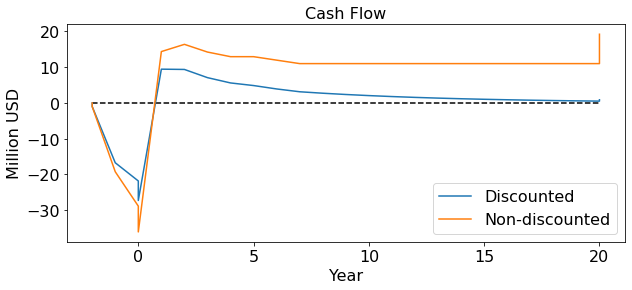

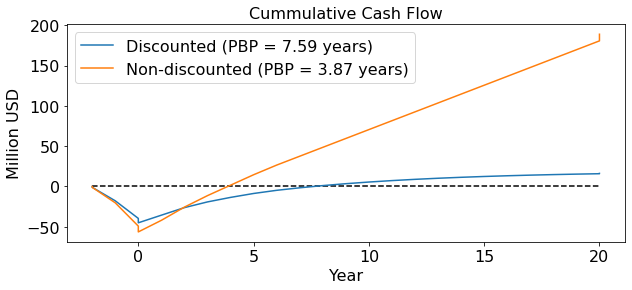

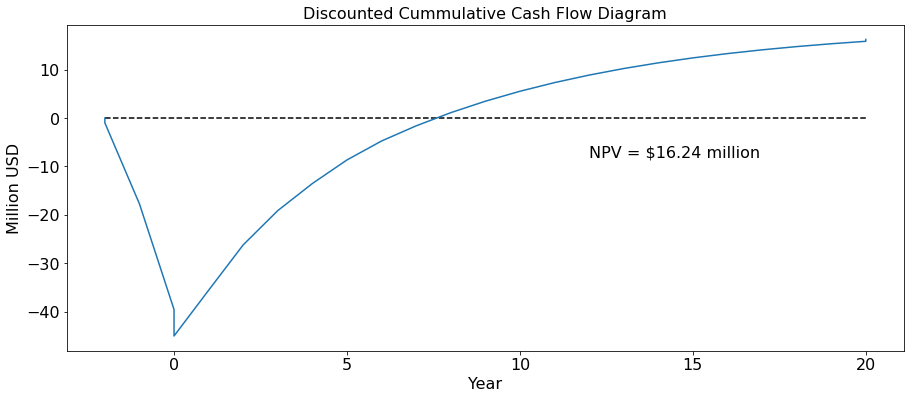

In [26]:

#Parameters given
MARR       = 0.15
depr       = [0.2,0.32,0.192,0.1152,0.1152,0.0576]  #allowed deprec
while len(depr)<20:
    depr.append(0)

T          = 0.35                 #tax 
t_c        = 2                    #years construction
P_ben      = 0.48                 #$/lb
P_pro      = 0.56                 #$/lb
P_pro_5    = 0.21                 #$/lb
P_cum      = 0.68                 #$/lb
stream_fac = 0.9                  #parts of the year worked (0.9 *365)
price_kw   = 1.3E-4               #$/kwh
PLand = 1e6                       #$

#ADDING CATALYST TO THE CASH FLOW
v     =  10/0.0283168  #ft^3
P_cat = 1000*v/3     

#HYSYS DATA
Q         = 19960              
'''
Changed
'''       
mass_benz = 12920                    #lb/hr#lb/hr cumene    
mass_pro  = 7903                     #lb/hr

non_p_s   = 8    
'''
Changed, was 12''' #non particulate steps in the process
p_steps   = 0

#COST OF RAW MATERIALS  (kg per hour input)
def CRM(Mb,Mp):
    pb = 365*0.9*24*Mb*P_ben
    pp = 365*0.9*24*Mp*P_pro_5
    return pb+pp

#N. PROCESS OPERATORS PER SHIFT
def NOL(Nnp):                           
    return (6.29+31.7*p_steps**2 + 0.23*Nnp)**0.5 
'''
    added p_steps'''

#OPERATING LABOR COST
def COL(nol): 
    NOL       = 4.5*nol
    year_wage = 66910*594/541.7   
    '''
    Used the wage for 2016 in the book and CEPCI to find current wage'''#70000     
    col       = year_wage*NOL
    return col

#EQ 8.2 COST OF MANUFACTURING WITHOUT DEPR
def COMD(FCI,Col,Cut,Cwt,Crm):
    comd = 0.180*FCI+2.73*Col+1.23*(Cut+Cwt+Crm)
    return comd

def after_tax(Revenue,Comd,d):
    return (Revenue-Comd-d)*(1-T)

def cash_flow(Revenue,Comd,d):
    return (Revenue-Comd-d)*(1-T)+d

def R(Q):
    return Q*P_cum*24*365*0.9

#REVENUE
revenue = R(Q)

############################
#MANUFACTURING COSTS
nol = NOL(non_p_s)  #number of employees  
col = COL(nol)
cut = 2e6                          #see page 222 (Matt on 3/26) 
cwt = 0
crm = CRM(mass_benz,mass_pro) + P_cat
cost_manufacturing = COMD(fci,col,cut,cwt,crm)
print('raw material cost', crm)
print('cost of labor', col)
print('the cost of manufacturing is', cost_manufacturing)

#DEPRECIATION
d = (fci*np.ones(len(depr)))*depr  #DEPRECIATION FOR THE TWENTY OPERATING YEARS IN ARRAY FORM
After_tax_cash = cash_flow(revenue,cost_manufacturing,d)   #cash flow for the twenty working years


   
'''
Make sure this is added'''#Average $ spent on catalyst each year  

#CASH FLOW FOR PLOTS
working_capital = 0.15*fci                         #change 
construction_cash_flow = [-PLand,-0.4*fci,-0.6*fci,-0.6*fci-working_capital]
salvage = working_capital+PLand
Final_point = salvage+After_tax_cash[-1]     #money made back after the plant is sold
cash_flow = np.append(construction_cash_flow,np.append(After_tax_cash,Final_point))

'''
New Code 
'''
# Cash flow and cummulative cash flow
construction_cash_flow = [0,-PLand,-0.4*fci,-0.6*fci-working_capital]
cash_flow = np.append(construction_cash_flow,After_tax_cash)

construction_cash_flow_xpts = [0,-PLand,-0.4*fci,-0.6*fci,-0.6*fci-working_capital]
cash_flow_xpts = np.append(construction_cash_flow_xpts,np.append(After_tax_cash,Final_point))
t1 = [-2,-2,-1,0,0]
t2 = np.linspace(1,20,20)
t = np.append(t1,np.append(t2,20))

cum_cash_flow_xpts = np.zeros(len(cash_flow_xpts))
for i in range(0,len(cum_cash_flow_xpts)):
    if i == 0:
        cum_cash_flow_xpts[i] = 0
    elif i == 4:
        cum_cash_flow_xpts[i] = sum(cash_flow_xpts[0:i+1]) - cash_flow_xpts[3]
    elif i == 25:
        cum_cash_flow_xpts[i] = sum(cash_flow_xpts[0:i+1]) - cash_flow_xpts[3] - cash_flow_xpts[24]
    elif i > 4 and i != 25:
        cum_cash_flow_xpts[i] = sum(cash_flow_xpts[0:i+1]) - cash_flow_xpts[3]
    else:
        cum_cash_flow_xpts[i] = sum(cash_flow_xpts[0:i+1])

dis_cash_flow_xpts = np.zeros(len(cash_flow_xpts))
for i in range(len(dis_cash_flow_xpts)):
    dis_cash_flow_xpts[i] = cash_flow_xpts[i] / (1+MARR)**(t[i] + 2)

dis_cum_cash_flow_xpts = np.zeros(len(cum_cash_flow_xpts))
for i in range(0,len(cum_cash_flow_xpts)):
    if i == 0:
        dis_cum_cash_flow_xpts[i] = 0
    elif i == 4:
        dis_cum_cash_flow_xpts[i] = sum(dis_cash_flow_xpts[0:i+1]) - dis_cash_flow_xpts[3]
    elif i == 25:
        dis_cum_cash_flow_xpts[i] = sum(dis_cash_flow_xpts[0:i+1]) - dis_cash_flow_xpts[3] - dis_cash_flow_xpts[24]
    elif i > 4 and i != 25:
        dis_cum_cash_flow_xpts[i] = sum(dis_cash_flow_xpts[0:i+1]) - dis_cash_flow_xpts[3]
    else:
        dis_cum_cash_flow_xpts[i] = sum(dis_cash_flow_xpts[0:i+1])

def IRRfunc(irr,Cn):
    sum0 = 0
    for i in range(len(Cn)):
        if i == len(Cn)-1:
            sum0 = sum0 + (Cn[i]+salvage)/(1+irr)**(i)
        else:
            sum0 = sum0 + Cn[i]/(1+irr)**(i)
    return sum0
irr = fsolve(IRRfunc,.005, args = (cash_flow[1:],))[0]
NPV = IRRfunc(MARR,cash_flow[1:])

print('IRR =',round(irr*100,2), '%')
print('NPV =',round(NPV/(1E6),2), 'mil $')

# Payback Periods

PBPNDfunc = interp1d(t,cum_cash_flow_xpts)
PBPDfunc = interp1d(t,dis_cum_cash_flow_xpts)
PBPND = ridder(PBPNDfunc,1,20)
PBPD = ridder(PBPDfunc,1,20)
print(f'Non-discounted Payback Period = {PBPND:.2f} years')
print(f'Non-discounted Payback Period = {PBPD:.2f} years')


plt.figure(figsize=(10,4))
plt.title('Cash Flow', fontsize = 16)
plt.plot([t[0],t[-1]],[0,0], 'k--')
plt.plot(t,dis_cash_flow_xpts/1e6, label='Discounted')
plt.plot(t,cash_flow_xpts/1e6, label='Non-discounted')
plt.legend(fontsize = 16)
plt.xlabel('Year', fontsize = 16)
plt.ylabel('Million USD', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.savefig('Cash Flow.png')
plt.show()

plt.figure(figsize=(10,4))
plt.title('Cummulative Cash Flow', fontsize = 16)
plt.plot([t[0],t[-1]],[0,0], 'k--')
plt.plot(t,dis_cum_cash_flow_xpts/1e6, label=f'Discounted (PBP = {PBPD:.2f} years)')
plt.plot(t,cum_cash_flow_xpts/1e6, label=f'Non-discounted (PBP = {PBPND:.2f} years)')
plt.legend(fontsize = 16)
plt.xlabel('Year', fontsize = 16)
plt.ylabel('Million USD', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
# plt.text(-2,150,f'Non-discounted PBP = {PBPND:.2f} years', fontsize = 16)
# plt.text(-2,130,f'Discounted PBP = {PBPD:.2f} years', fontsize = 16)
plt.savefig('Cummulative Cash Flow.png')
plt.show()

plt.figure(figsize=(15,6))
plt.title('Discounted Cummulative Cash Flow Diagram', fontsize = 16)
plt.plot([t[0],t[-1]],[0,0], 'k--')
plt.plot(t,dis_cum_cash_flow_xpts/1e6, label='Discounted')
plt.xlabel('Year', fontsize = 16)
plt.ylabel('Million USD', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.text(12,-8,f'NPV = ${NPV/1e6:.2f} million', fontsize = 16)
plt.savefig('Discounted Cummulative Cash Flow Diagram.png')
plt.show();